## Imports and declerations

In [1]:
import pickle
import os
import string
import pandas as pd
import re
import math
import pprint
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import copy
from copy import deepcopy
import random
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
InteractiveShell.ast_node_interactivity = "all"

## Data Structure:

In [2]:

class VectorSpaceModel(object):
    
    def tf_natural(self, tf, doc):
    #return tf
        return tf / sum(doc.values())
    def idf_no(self, term):
        return 1
    def idf_idf(self, term):
        return math.log10((len(self.docs.keys()) / (len(self.index[term]))) + 1 )
    def norm_cosine(doc):
        return 1 / (sum([tf**2 for tf in doc.values()]) + 1)
    def norm_no(self, doc):
        return 1  
    def __init__(self, tf_func = 'natural', idf_func = 'idf', norm_func='none'):
        self.tf_functions = {
            'natural': self.tf_natural,
            # 'logarithm': lambda tf, doc : (0 if tf==0 else 1 + math.log10(tf)),
            # 'augmented': lambda tf, doc : (0.5 + ((0.5 * tf)/(self.find_max_tf(doc)))),
            # 'boolean' : lambda tf, doc : (1 if tf > 0 else 0),
            # 'log_ave': self.tf_log_ave

        }
        self.idf_functions = {
            'no': self.idf_no,
            'idf':self.idf_idf,
            'prob_idf' : self.prod_idf
        }
        self.normailization_functions = {
            'none' : self.norm_no,
            'cosine' : self.norm_cosine,
#             'pivoted_unique' : lambda 
        }
        self.tf_func = self.tf_functions[tf_func]
        self.idf_func = self.idf_functions[idf_func]
        self.norm_func = self.normailization_functions[norm_func]

        self.vocab = {}
        self.vocab_idf = {}
        self.docs = {}
        self.docs_char_length = {}
        self.occurrance = {}
        self.occurrance2 = {}
        self.cdocs = {}
        self.index = {}
        def tf_log_ave(self, tf, doc):
    #         print(tf)
            return ( (1+math.log10((tf*sum(doc.values()))+1)) / (1 + math.log10(self.find_avg_tf(doc))))
    def prod_idf(self, term):
#         print('prob idf')
#         print(math.log10((len(self.docs.keys()) - (len(self.index[term])) + 1)/(len(self.index[term]))))
        if 0 > math.log10((len(self.docs.keys()) - (len(self.index[term])) + 1)/(len(self.index[term]))):
            return 0;
        else:
            return math.log10((len(self.docs.keys()) - (len(self.index[term])) + 1)/(len(self.index[term])))    
    
    
    def find_avg_tf(self, doc):
        csum = 0
        cnt = 0
#         print(f'Doc sum : {sum(doc.values()) }')
#         print(sum(doc.values()) / len(doc.keys()))
        return (sum(doc.values()) / len(doc.keys()))
    
    def find_max_tf(self, doc):
        max_tf = 0
        max_term = None
        for term, tf in doc.items():
            if tf > max_tf:
                max_tf = tf
                max_term = term
        return max_tf

    
    
    def create_doc(self, docId):
        self.docs[docId] = dict.fromkeys(self.vocab, 0)
        
    def add_term(self, term, docId, position):
        if term not in self.vocab.keys():
            self.vocab[term] = 1
            for Id, docList in self.docs.items():
                self.docs[Id][term] = 0
        else:
            self.vocab[term]+=1
        
        if term in self.docs[docId].keys():
            self.docs[docId][term] += 1
        else:
            self.docs[docId][term] = 1
            
        if docId not in self.occurrance.keys():
            self.occurrance[docId] = {}
            self.occurrance[docId][term] = []
            self.occurrance[docId][term].append(position)
        else:
            if term not in self.occurrance[docId].keys():
                self.occurrance[docId][term] = []
                self.occurrance[docId][term].append(position)
            else:
                self.occurrance[docId][term].append(position)
                
        if term in self.index.keys():
            self.index[term].add(docId)
        else:
            self.index[term] = set()
            self.index[term].add(docId)
#         if docId not in self.occurrance.keys():
#             self.occurrance[docId] = []
#         self.occurrance[docId].append(position)
    
    def get_query_vector(self, query_terms):
        query_vector_hash = dict.fromkeys(self.vocab, 0)
#         print(query_vector_hash)
        query_terms = [lem.lemmatize(word.lower()) for word in query_terms]
        print(query_terms)
        for term in query_terms:
            if term in query_vector_hash.keys():
                query_vector_hash[term] += 1

        
        words_in_query = len(query_terms)
        tf = dict.fromkeys(self.vocab_idf, 0) 
        tf_idf = dict.fromkeys(self.vocab_idf, 0)
        
        for term,term_cnt in query_vector_hash.items():
            if term_cnt <= 0:
                continue
#                 print(term)
#                 print(term_cnt)
#                 tf[term] = term_cnt / words_in_query
#                 idf[term] = len(self.docs.keys()) / (self.vocab[term])

            tf[term] = self.tf_func( term_cnt,query_vector_hash )
            tf_idf[term] = tf[term] *  self.vocab_idf[term]
            print(f'tf_idf {term}: {tf_idf[term]}')
        new_query_vector_hash = {
            'tf': tf,
            'idf':self.vocab_idf,
            'tf_idf':tf_idf
        }
    
    
        return new_query_vector_hash
    
    def dot_product(self, v_hash_1, v_hash_2):
#         print(len(v_hash_1))
#         print(len(v_hash_2))
#         print('vhash')
#         print(v_hash_2)
        return sum([v_hash_2[x]*y for x,y in v_hash_1.items()])
        
    def get_magnitude(self, v_hash):
        
        mag = sum([x**2 for x in v_hash.values()]) ** 0.5 
        if mag == 0:
            return 1
        return mag
    
    
    def get_cosine_sim(self, v_hash_x, v_hash_y):
        return (self.dot_product(v_hash_x,v_hash_y)) / (self.get_magnitude(v_hash_x) * self.get_magnitude(v_hash_y)) 
            
    def get_ranking(self, query_vector_hash):
        ranked_docs = []
        for docId,doc_vector_hash in self.cdocs.items():
            cosine_sim = self.get_cosine_sim(doc_vector_hash['tf_idf'], query_vector_hash['tf_idf'])
            ranked_docs.append((docId, cosine_sim))
        ranked_docs = sorted(ranked_docs, key=lambda x:x[1])
        return ranked_docs
    
    def calculate_tf_idf(self):
        cdocs = {}
        self.vocab_idf = dict.fromkeys(self.vocab, 0)
        for term, term_cnt in self.vocab.items():
            self.vocab_idf[term] = self.idf_func(term)
            
        for docId,doc in self.docs.items():
#             print(doc.values())
            words_in_d = sum(doc.values())
            tf = {}
        
            tf_idf = {}
            for term,term_cnt in doc.items():
#                 tf[term] = term_cnt / words_in_d
#                 idf[term] = len(self.docs.keys()) / (self.vocab[term])
                tf[term] =self.tf_func(term_cnt, doc)
                tf_idf[term] = tf[term] * self.vocab_idf[term]
            cdocs[docId] = {
                'tf': tf,
                'tf_idf':tf_idf,
                'total_words' : words_in_d
            }
        self.cdocs = cdocs
        return self.cdocs
            
        

In [3]:
test_space = VectorSpaceModel()

d1= "Music is a universal language"
d2= "Music is a miracle"
d3= "Music is a universal feature of the human experience"
# test_space.create_doc(1)
# for word in d1.split(' '):
#     test_space.add_term(word, 1)
# test_space.create_doc(2)
# for word in d2.split(' '):
#     test_space.add_term(word, 2)
# test_space.create_doc(3)
# for word in d3.split(' '):
#     test_space.add_term(word, 3)
# test_space.calculate_tf_idf()


## Helper Functions:

In [4]:
# Remove Punctuation
def remove_punctuation(word):
    return word.translate(word.maketrans('','',string.punctuation))

# Clean Query Term
def clean_word(word):
    # Case Folding
    word = word.lower()
     # Filter non-ASCII characters
    word = ''.join(filter(lambda x: x in printable, word))
#     print(word)
    # Remove Punctuations
    if word != '(' and word != ')':
        word = remove_punctuation(word)
#     print(word)
    if re.match('\d+[A-Za-z]+',word):
        word = re.split('\d+',word)[1]
    if re.match('[A-Za-z]+\d+',word):
        word = re.split('\d+',word)[0]
#     print(word)
    word = ps.stem(word)
#     print(word)
    return word

In [5]:
os.path.join('data','bbcsport', next(os.walk(os.path.join('data','bbcsport', 'athletics')))[2][0])

'data\\bbcsport\\001.txt'

In [6]:
def clean_str(stri):
    """
    Tokenization/stri cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    stri = re.sub(r"\'s", "", stri)
    stri = re.sub(r"\'ve", "", stri)
    stri = re.sub(r"n\'t", "", stri)
    stri = re.sub(r"\'re", "", stri)
    stri = re.sub(r"\'d", "", stri)
    stri = re.sub(r"\'ll", "", stri)
    stri = re.sub(r",", "", stri)
    stri = re.sub(r"!", " ! ", stri)
    stri = re.sub(r"\(", "", stri)
    stri = re.sub(r"\)", "", stri)
    stri = re.sub(r"\?", "", stri)
    stri = re.sub(r"'", "", stri)
    stri = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", stri)
    stri = re.sub(r"[0-9]\w+|[0-9]","", stri)
    stri = re.sub(r"\s{2,}", " ", stri)
    return stri.strip().lower()

def remove_empty_lines(lines):
    new_line = []
    for line in lines:
        if line == '\n':
            continue
        new_line.append(line.replace('\t', '').replace('\n', '').replace('\\',''))
    return new_line
        
def extract_vocab():
    vocab = set()
    docs = {}
    printable = set(string.printable) 
    raw_data = []
    # Printable characters are
    # 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
    # !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c
    lem = WordNetLemmatizer() 
    ps = PorterStemmer()
    classes = next(os.walk(os.path.join('data','bbcsport')))[1]
    for c in classes:
        docs_in_c = next(os.walk(os.path.join('data','bbcsport', c)))[2]
        print(c)
        for doc in docs_in_c:
#             print(f'\t{doc}',end=',')
            with open(os.path.join('data','bbcsport', c, doc), 'r') as file1:
                lines = file1.readlines()
    
            
                for line_no,line in enumerate(lines):
                    
                    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
                    for i in symbols:
                        line = line.replace(i, ' ')
                    for word in re.split('[.\s,?!:;-]', line):
                        
                        # Case Folding
                        word = word.lower()

                        # Filter non-ASCII characters
                        word = ''.join(filter(lambda x: x in printable, word))
                        
                        if word in stop_words:
                            continue

                        # Remove Punctuations
                        word = remove_punctuation(word)

                        if re.match('\d+[A-Za-z]+',word):
                            word = re.split('\d+',word)[1]
                        if re.match('[A-Za-z]+\d+',word):
                            word = re.split('\d+',word)[0]
                            
                        if len(word) == 0 or len(word) == 1 or word == '' or word == ' ':
                            continue


                        word = ps.stem(word)

                
                        vocab.add(word)
    print(f'Vocab Size : {len(vocab)}')
    vocab_list = sorted(list(vocab))
    vocab_hash = dict.fromkeys(vocab_list, 0)
    vocab_index = { word:index for index,word in enumerate(vocab_list)}
    return vocab_index


def extract_vectors(vocab_index):
    docs = {}
    printable = set(string.printable) 
    raw_data = []
    X = []
    y = []
    # Printable characters are
    # 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
    # !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c
    lem = WordNetLemmatizer() 
    ps = PorterStemmer()
    classes = next(os.walk(os.path.join('data','bbcsport')))[1]
    for c in classes:
        docs_in_c = next(os.walk(os.path.join('data','bbcsport', c)))[2]
        print(c)
        for doc in docs_in_c:
#             print(f'\t{doc}',end=',')
            doc_vector = np.zeros((len(vocab_index)))
            with open(os.path.join('data','bbcsport', c, doc), 'r') as file1:
                lines = file1.readlines()
                for line_no,line in enumerate(lines):
                    
                    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
                    for i in symbols:
                        line = line.replace(i, ' ')
                    for word in re.split('[.\s,?!:;-]', line):
                        
                        # Case Folding
                        word = word.lower()

                        # Filter non-ASCII characters
                        word = ''.join(filter(lambda x: x in printable, word))

                        if word in stop_words:
                            continue
                        
                        # Remove Punctuations
                        word = remove_punctuation(word)

                        if re.match('\d+[A-Za-z]+',word):
                            word = re.split('\d+',word)[1]
                        if re.match('[A-Za-z]+\d+',word):
                            word = re.split('\d+',word)[0]

                        if len(word) == 0 or len(word) == 1 or word == '' or word == ' ':
                            continue
                        
#                         print(word)
#                         print(vocab_index[word])

                        word = ps.stem(word)

                        doc_vector[vocab_index[word]] += 1
                
                X.append(doc_vector)
                y.append(c)
                
    return (X,y)

def accuracy(y_test, pred):
        return len([1
                    for p, y in zip(pred, y_test) if p == y]) / len(pred) * 100
stop_words = set()
with open('Stopword-List.txt', 'r') as stop_word_file:
    lines = stop_word_file.readlines()
    for line in lines:
        stop_words.add(line.split('\n')[0])
#     stop_words.remove('')

vocab_index = extract_vocab()
(X,y) = extract_vectors(vocab_index)
number_of_docs = len(X)
feature_size = len(vocab_index)

# remove_empty_lines(['Claxton hunting first major medal\n', '\n', "British hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.\n", '\n', 'The 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. "I am quite confident," said Claxton. "But I take each race as it comes. "As long as I keep up my training but not do too much I think there is a chance of a medal." Claxton has won the national 60m hurdles title for the past three years but has struggled to translate her domestic success to the international stage. Now, the Scotland-born athlete owns the equal fifth-fastest time in the world this year. And at last week\'s Birmingham Grand Prix, Claxton left European medal favourite Russian Irina Shevchenko trailing in sixth spot.\n', '\n', 'For the first time, Claxton has only been preparing for a campaign over the hurdles - which could explain her leap in form. In previous seasons, the 25-year-old also contested the long jump but since moving from Colchester to London she has re-focused her attentions. Claxton will see if her new training regime pays dividends at the European Indoors which take place on 5-6 March.\n'])

athletics
cricket
football
rugby
tennis
Vocab Size : 9494
athletics
cricket
football
rugby
tennis


In [7]:
print(vocab_index.keys())

dict_keys(['00', '000', '01', '0100', '016', '02', '0227', '03', '0315', '033', '04', '0400', '05', '06', '060', '0600', '07', '0800', '0830', '09', '0900', '093', '10', '100', '101', '102', '103', '1030', '104', '105', '106', '107', '108', '109', '11', '110', '1100', '111', '112', '113', '114', '115', '116', '117', '119', '12', '120', '1200', '121', '122', '123', '1230', '124', '125', '128', '129', '13', '1300', '131', '132', '133', '1330', '134', '135', '136', '137', '138', '139', '14', '140', '1400', '142', '143', '1430', '145', '146', '147', '149', '15', '150', '1500', '151', '152', '153', '155', '156', '158', '16', '160', '1600', '161', '163', '164', '165', '168', '169', '17', '170', '172', '173', '178', '179', '18', '180', '181', '1815', '182', '183', '1830', '184', '185', '186', '187', '1870', '1871', '188', '1888', '189', '1893', '19', '190', '1900', '1903', '1905', '1908', '191', '1912', '192', '1921', '1924', '1928', '1930', '1935', '1936', '1945', '1946', '1948', '195', '195

In [8]:
len([col for col, val in pd.DataFrame(X).iloc[:, :-1].sum().iteritems() if int(val) > 3])

4179

In [9]:
features = np.array(X)
features.shape
data = pd.DataFrame(X)
data.drop([col for col, val in pd.DataFrame(X).sum().iteritems() if int(val) <= 3], axis = 1, inplace=True)
# data['label'] = y
data.shape

(737, 9494)

(737, 4180)

In [10]:
list(data.sum().apply(lambda df: np.log10(number_of_docs / (df + 1))))

[1.1271047983648077,
 2.089316237475408,
 2.089316237475408,
 0.6660703635385999,
 1.323399443508776,
 2.1684974835230326,
 1.9643775008671078,
 2.1684974835230326,
 1.0479235523171828,
 2.089316237475408,
 2.089316237475408,
 2.1684974835230326,
 0.9279482352404329,
 2.022369447844795,
 2.089316237475408,
 1.010134991427783,
 2.1684974835230326,
 2.1684974835230326,
 1.1271047983648077,
 2.089316237475408,
 2.1684974835230326,
 1.054554131216196,
 2.022369447844795,
 1.0821376528482844,
 2.022369447844795,
 0.9132249784197266,
 0.9229848157088828,
 2.022369447844795,
 1.8674674878590516,
 1.0966154762169074,
 2.1684974835230326,
 1.8260748027008264,
 2.022369447844795,
 2.1684974835230326,
 2.1684974835230326,
 2.022369447844795,
 2.1684974835230326,
 2.022369447844795,
 2.089316237475408,
 2.089316237475408,
 1.9643775008671078,
 2.022369447844795,
 2.1684974835230326,
 1.7882862418114267,
 1.7213394521808134,
 2.089316237475408,
 1.9643775008671078,
 1.6633475052031268,
 1.287683891

In [11]:
data.mul(data.sum().apply(lambda df: np.log10(number_of_docs / (df + 1))), axis = 1)

,1,10,16,22,23,24,30,33,34,35,...,9472,9473,9477,9481,9482,9484,9486,9488,9492,9493
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.0,2.089316,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
data

,1,10,16,22,23,24,30,33,34,35,...,9472,9473,9477,9481,9482,9484,9486,9488,9492,9493
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data['label'] = y
shuffled_data = data

shuffled_data.sample(frac=1)
train_size = 0.8
test_size = 0.2

train_data, test_data = shuffled_data.sample(frac=train_size) ,shuffled_data.sample(frac=test_size) 
X_train, y_train = train_data.loc[:, train_data.columns != 'label'], train_data['label']
X_test, y_test = test_data.loc[:, test_data.columns != 'label'], test_data['label']



,1,10,16,22,23,24,30,33,34,35,...,9473,9477,9481,9482,9484,9486,9488,9492,9493,label
570,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rugby
702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tennis
184,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cricket
643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tennis
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,athletics
221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cricket
365,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,football
289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,football
684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tennis
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cricket


In [14]:
test_data

,1,10,16,22,23,24,30,33,34,35,...,9473,9477,9481,9482,9484,9486,9488,9492,9493,label
469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,football
356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,football
510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rugby
709,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tennis
367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,football
115,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cricket
556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rugby
692,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,tennis
37,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,athletics
271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,football


In [15]:
%%time
def euclidian_distance(p1, p2):
    return ((p2-p1).map( (lambda x: x**2))).sum() ** 0.5
def cosine_similarity(p1, p2):
    return (sum(p2.values*p1.values) / ((p1.map(lambda x: x**2).sum() ** 0.5) * (p2.map(lambda x: x**2).sum() ** 0.5)) ) 

class KNNClassifier():
    
    
    def __init__(self, neighbors = 5, distance_formula = euclidian_distance):
        self.distance_formula = distance_formula
        self.neighbors = neighbors
        self.X_train = []
        self.y_train = []
        
    def fit(self, X, y):
        self.X_train = X
        self.y = y
    def predict(self, X_test):
        pred = []
        for index, test_row in X_test.iterrows():
            print(index)
            pred.append(self.X_train.apply((lambda row : self.distance_formula(row, test_row)), axis=1).sort_values(ascending=False))
        return pred
        
knn = KNNClassifier(distance_formula=cosine_similarity)
knn.fit(X_train, y_train)
print(X_test.shape)
pred = knn.predict(X_test)


(147, 4180)
469
356
510
709
367
115
556
692
37
271
8
2
643
150
531
180
637
691
289
579
431
61
512
252
502
209
540
90
610
210
688
307
275
108
262
508
442
618
124
138
674
279
380
524
668
413
621
632
457
191
503
314
698
55
250
685
285
718
596
670
321
473
620
303
721
500
111
51
229
653
139
646
334
504
492
129
74
195
5
283
18
17
338
614
598
451
645
280
652
277
160
264
355
232
729
245
0
506
578
91
196
702
607
346
430
448
125
548
727
722
179
516
302
501
365
153
486
80
444
434
642
511
88
539
131
393
347
553
661
588
106
700
523
189
19
507
499
634
197
370
565
456
564
204
287
299
601
Wall time: 6min 42s


In [56]:

# [0 for x in X_train.iloc[0].index]
# for c in range(0, 3):

# ar = np.array([X_train.sample().values] * 3)
# ar = ar.reshape( 3, len(X_train.iloc[0]))
# print(ar.shape)




# pd.DataFrame([], columns = X_train.iloc[0].index)

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
          ...   
4150    0.000000
4151    0.000000
4152    0.000000
4153    0.000000
4154    0.000000
4155    0.000000
4156    0.000000
4157    0.000000
4158    0.000000
4159    0.000000
4160    0.000000
4161    0.000000
4162    0.000000
4163    0.000000
4164    0.000000
4165    0.000000
4166    0.000000
4167    0.000000
4168    0.000000
4169    0.000000
4170    0.666667
4171    0.000000
4172    0.000000
4173    0.000000
4174    0.000000
4175    0.000000
4176    0.000000
4177    0.0000

In [ ]:
class KMeansCluter():
    def __init__(self, num_clusters = 2):
        self.num_clusters = num_clusters
        self.max_iterations = 1000
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        self.centroids = []
        for c in range(0, self.num_clusters):
            self.centroids.append(pd.DataFrame(X_train.sample(3).values).apply(sum, axis=0) / 3)
        
        for iteration in range(0, self.max_iterations):
            
        

In [89]:
new_pred = [x[:3] for x in pred]
pred

[669    1.000000
 714    0.460469
 674    0.382087
 660    0.365494
 662    0.277057
 638    0.276818
 684    0.273090
 706    0.271488
 736    0.269351
 723    0.267176
 721    0.263889
 722    0.256495
 699    0.251727
 726    0.248929
 692    0.248830
 704    0.248316
 690    0.247681
 707    0.245106
 688    0.243289
 702    0.242007
 666    0.240609
 68     0.238919
 693    0.234663
 657    0.230089
 57     0.225736
 637    0.224214
 711    0.222883
 675    0.219474
 69     0.218778
 651    0.215003
          ...   
 25     0.025794
 255    0.025452
 34     0.025063
 441    0.025000
 81     0.024515
 292    0.023837
 253    0.023749
 483    0.021664
 323    0.021607
 259    0.020752
 417    0.020620
 501    0.020309
 300    0.019385
 604    0.019174
 50     0.019024
 329    0.018804
 3      0.018282
 261    0.018089
 364    0.015875
 216    0.015749
 273    0.015408
 49     0.015386
 698    0.012859
 374    0.011014
 79     0.011014
 472    0.010583
 419    0.008333
 321    0.0064

In [90]:
new_pred

[669    1.000000
 714    0.460469
 674    0.382087
 dtype: float64, 603    1.000000
 163    0.327414
 551    0.278186
 dtype: float64, 528    0.313583
 612    0.260485
 547    0.249466
 dtype: float64, 251    1.000000
 242    0.999235
 373    0.539559
 dtype: float64, 668    1.000000
 645    0.343206
 660    0.303626
 dtype: float64, 156    1.000000
 101    0.642675
 145    0.378245
 dtype: float64, 579    1.000000
 581    0.570775
 548    0.515712
 dtype: float64, 221    0.701146
 220    0.619232
 213    0.556521
 dtype: float64, 541    1.000000
 546    0.387500
 619    0.379398
 dtype: float64, 589    1.000000
 557    0.495678
 548    0.437153
 dtype: float64, 496    1.000000
 529    0.496123
 621    0.490641
 dtype: float64, 104    0.530330
 137    0.518318
 126    0.516935
 dtype: float64, 149    1.000000
 119    0.495328
 172    0.438421
 dtype: float64, 401    1.000000
 455    0.435102
 444    0.338126
 dtype: float64, 418    1.000000
 314    0.359066
 252    0.314707
 dtype: flo

In [91]:
len(y)

737

In [92]:
from collections import Counter
label_pred = []
for indexes in new_pred:
    labels = []
#     print(indexes)
    for index, value in indexes.items():
#         print(index)
#         print(y[index])
        labels.append(y[index])
    label_pred.append(Counter(labels).most_common(1)[0][0])
label_pred
accuracy(y_test,label_pred)

['tennis',
 'rugby',
 'rugby',
 'football',
 'tennis',
 'cricket',
 'rugby',
 'cricket',
 'rugby',
 'rugby',
 'rugby',
 'cricket',
 'cricket',
 'football',
 'football',
 'tennis',
 'tennis',
 'tennis',
 'athletics',
 'football',
 'football',
 'football',
 'football',
 'tennis',
 'football',
 'tennis',
 'tennis',
 'athletics',
 'rugby',
 'athletics',
 'football',
 'football',
 'tennis',
 'tennis',
 'rugby',
 'football',
 'rugby',
 'athletics',
 'rugby',
 'football',
 'tennis',
 'football',
 'football',
 'rugby',
 'cricket',
 'rugby',
 'athletics',
 'football',
 'cricket',
 'football',
 'football',
 'cricket',
 'rugby',
 'rugby',
 'tennis',
 'football',
 'cricket',
 'rugby',
 'tennis',
 'football',
 'football',
 'rugby',
 'rugby',
 'football',
 'football',
 'athletics',
 'rugby',
 'football',
 'football',
 'cricket',
 'cricket',
 'rugby',
 'football',
 'football',
 'football',
 'cricket',
 'tennis',
 'football',
 'tennis',
 'athletics',
 'rugby',
 'rugby',
 'football',
 'tennis',
 'crick

99.31972789115646

In [242]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans


neigh = KNeighborsClassifier(n_neighbors=5, p=2,weights='distance')
neigh.fit(X_train,y_train)


pred = neigh.predict(X_test)
print(f'KNN Sciket Accuracy : {accuracy(y_test, pred)}')

kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train)
pred = kmeans.predict(X_test)
print(kmeans.labels_)
def map_classes(pred):
    classes = ['athletics','cricket','football','rugby','tennis']
    pred2 = [classes[x] for x in pred]
    return pred2
    
print(f'K Means Sciket Accuracy : {accuracy(y_test, map_classes(pred))}')
                    
                               


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

KNN Sciket Accuracy : 98.63945578231292
[3 2 2 3 3 3 2 3 2 3 3 3 2 2 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 2 3 2 3 3 3 3
 2 3 3 3 3 3 3 3 2 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 0 3
 3 3 2 3 3 3 3 2 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 2 3 3 3 3 3 3
 3 3 2 3 3 3 2 2 3 3 3 3 3 3 3 3 3 2 3 3 3 2 3 2 3 3 3 3 3 4 3 3 3 0 3 3 3
 2 3 2 2 3 3 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 3 3 2 2 2 3 3 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 2 3 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3 2 3
 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 2 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2
 3 2 3 3 3 2 3 3 3 3 3 2 2 2 2 3 3 3 3 3 2 3 3 2 3 2 2 3 3 3 3 2 3 3 2 3 3
 3 3 3 3 3 3 2 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3
 2 3 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 2 2 3 2 3 3 3 3 3 3 3 2 3 2 3 3 3 3 3 3
 3 3 3 2 3 3 2 0 3 3 3 2 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3
 3 3 3 3 2 2 3 3 3 3 3 3 3 2 3 3 2 3 3 3 2 3 3 3 3 2 3 3 3 3

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'K-means clustering on the digits dataset (PCA-reduced data)\nCentroids are marked with white cross')

(-4.738363056475418, 76.14844782673619)

(-40.68698450188073, 52.444715981230594)

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

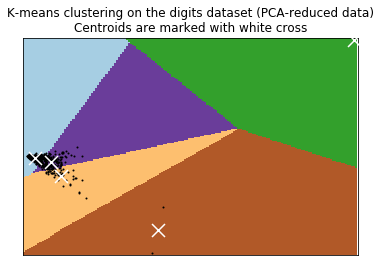

In [208]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(X_train)
kmeans = KMeans(n_clusters=5)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .5     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [176]:
vocab_hash = dict.fromkeys(vocab_list, 0)
vocab_index = { word:index for index,word in enumerate(vocab_list)}

In [93]:
list(enumerate(vocab_list))

[(0, '00'),
 (1, '000'),
 (2, '01'),
 (3, '0100'),
 (4, '016'),
 (5, '02'),
 (6, '0227'),
 (7, '03'),
 (8, '0315'),
 (9, '033'),
 (10, '04'),
 (11, '0400'),
 (12, '05'),
 (13, '06'),
 (14, '060'),
 (15, '0600'),
 (16, '07'),
 (17, '0800'),
 (18, '0830'),
 (19, '09'),
 (20, '0900'),
 (21, '093'),
 (22, '10'),
 (23, '100'),
 (24, '101'),
 (25, '102'),
 (26, '103'),
 (27, '1030'),
 (28, '104'),
 (29, '105'),
 (30, '106'),
 (31, '107'),
 (32, '108'),
 (33, '109'),
 (34, '11'),
 (35, '110'),
 (36, '1100'),
 (37, '111'),
 (38, '112'),
 (39, '113'),
 (40, '114'),
 (41, '115'),
 (42, '116'),
 (43, '117'),
 (44, '119'),
 (45, '12'),
 (46, '120'),
 (47, '1200'),
 (48, '121'),
 (49, '122'),
 (50, '123'),
 (51, '1230'),
 (52, '124'),
 (53, '125'),
 (54, '128'),
 (55, '129'),
 (56, '13'),
 (57, '1300'),
 (58, '131'),
 (59, '132'),
 (60, '133'),
 (61, '1330'),
 (62, '134'),
 (63, '135'),
 (64, '136'),
 (65, '137'),
 (66, '138'),
 (67, '139'),
 (68, '14'),
 (69, '140'),
 (70, '1400'),
 (71, '142'),
 

In [103]:
vocab_hash['claxton']

0

In [95]:
vocab_index

{'00': 0,
 '000': 1,
 '01': 2,
 '0100': 3,
 '016': 4,
 '02': 5,
 '0227': 6,
 '03': 7,
 '0315': 8,
 '033': 9,
 '04': 10,
 '0400': 11,
 '05': 12,
 '06': 13,
 '060': 14,
 '0600': 15,
 '07': 16,
 '0800': 17,
 '0830': 18,
 '09': 19,
 '0900': 20,
 '093': 21,
 '10': 22,
 '100': 23,
 '101': 24,
 '102': 25,
 '103': 26,
 '1030': 27,
 '104': 28,
 '105': 29,
 '106': 30,
 '107': 31,
 '108': 32,
 '109': 33,
 '11': 34,
 '110': 35,
 '1100': 36,
 '111': 37,
 '112': 38,
 '113': 39,
 '114': 40,
 '115': 41,
 '116': 42,
 '117': 43,
 '119': 44,
 '12': 45,
 '120': 46,
 '1200': 47,
 '121': 48,
 '122': 49,
 '123': 50,
 '1230': 51,
 '124': 52,
 '125': 53,
 '128': 54,
 '129': 55,
 '13': 56,
 '1300': 57,
 '131': 58,
 '132': 59,
 '133': 60,
 '1330': 61,
 '134': 62,
 '135': 63,
 '136': 64,
 '137': 65,
 '138': 66,
 '139': 67,
 '14': 68,
 '140': 69,
 '1400': 70,
 '142': 71,
 '143': 72,
 '1430': 73,
 '145': 74,
 '146': 75,
 '147': 76,
 '149': 77,
 '15': 78,
 '150': 79,
 '1500': 80,
 '151': 81,
 '152': 82,
 '153': 83,


In [37]:
#[x for x in os.walk(os.path.join('data','bbcsport'))]

## Term - Document Indexing:

In [18]:
vocab = set()
doc_contents = []

vector_space = VectorSpaceModel(tf_func='natural',idf_func='idf')
printable = set(string.printable) 
raw_data = []
# Printable characters are
# 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
# !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c


lem = WordNetLemmatizer() 

stop_words = set()
with open('Stopword-List.txt', 'r') as stop_word_file:
    lines = stop_word_file.readlines()
    for line in lines:
        stop_words.add(line.split('\n')[0])
    stop_words.remove('')

    
print('Loading : ', end='')
for file_number in range(0, 56):
    vector_space.create_doc(file_number)
    with open(f'data/Trump Speechs/speech_{file_number}.txt', 'r') as file1:
        lines = file1.readlines()
#         print(f'File Number : speech_{file_number}.txt' )
#         print(lines[0])
        position = {'doc':file_number,'row':0, 'col':0, 'token_no':0}
        
#         {
#             'total_count' : 0,
#             'postings' : {
#                 'count':0,
#                 'doc_id':0,
#                 'positions':[]
#             }
#         }
        
        for line_no,line in enumerate(lines):
            # Skip Heading Line
            if line_no == 0:
                continue
            doc_set = set()
            # split words at . , whitespace ? ! : ;
            position['row'] = line_no 
            position['col'] = 0
            symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
            for i in symbols:
                line = line.replace(i, ' ')
            raw_data.append(line)
            for word in re.split('[.\s,?!:;-]', line):
                
                position['col'] += len(word) + 1
                position['token_no'] += 1
                # Case Folding
                word = word.lower()
                
                # Filter non-ASCII characters
                word = ''.join(filter(lambda x: x in printable, word))
                
                # Remove Punctuations
                word = remove_punctuation(word)
                
                if re.match('\d+[A-Za-z]+',word):
                    word = re.split('\d+',word)[1]
                if re.match('[A-Za-z]+\d+',word):
                    word = re.split('\d+',word)[0]
                
                if len(word) == 0 or len(word) == 1 or word == '' or word == ' ':
                    continue
                if word in stop_words:
                    continue
                
                word = lem.lemmatize(word)
                    
                vocab.add(word)
                
                doc_set.add(word)
                
                vector_space.add_term(word, file_number, deepcopy(position))
                
        doc_contents.append(doc_set)
        print('*', end='')
doc_term_tf_idf = vector_space.calculate_tf_idf()
print('Done')

Loading : ********************************************************Done


In [19]:
print('Total Vocabulary Size ')
print(len(vector_space.index.keys()))
print('Total Number of Documents ')
print(len(vector_space.docs))

Total Vocabulary Size 
6249
Total Number of Documents 
56


In [20]:
# To save Inverted Index in File
with open('pickled/vector_space.p', 'wb') as index_file:
    pickle.dump(vector_space, index_file)

In [21]:
query = "Hillary clinton"
query_terms = [lem.lemmatize(x) for x in query.split(' ')]
print(query_terms)

query_vector = vector_space.get_query_vector(query_terms)

# cs = vector_space.get_cosine_sim(vector_space.docs[1], query_vector)
# print([(x,y) for x,y in query_vector.items() if y > 0])
# ranked = vector_space.get_ranking(vector_space.get_query_vector(query_terms))
# ranked.reverse()
# ranked = set([x for x,y in ranked if y > 0.0005])
# print(ranked)

vector_space.index['global']

['Hillary', 'clinton']
['hillary', 'clinton']
tf_idf clinton: 0.15657531416991727
tf_idf hillary: 0.15871020592607524


{1, 2, 9, 16, 20, 31, 32, 36, 40, 42, 43, 44, 46, 52}

# Query Tests:

In [22]:
test = [(None, None) for x in range(0, 17)] 
test[0] =("massive inflow of refugees",
{'32', '50', '49', '47', '46', '29', '48', '54', '41', '40', '30', '39', '12', '52', '37', '44', '31', '38', '20'}
         )
test[1] =('pakistan afghanistan',
{'3', '22', '16', '17', '4', '1'}
         )
test[2] =('Hillary Clinton',
{'4', '12', '36', '42', '33', '20', '29', '35', '16', '22', '47', '34', '14', '21', '45', '46', '41', '11', '3', '51', '53', '40', '37', '17', '48', '39', '5', '28', '10', '18', '54', '44', '25', '43', '49', '24', '30', '32', '8', '50', '9', '26', '7', '19', '52', '31', '27', '6', '2', '38', '1', '55'}
         )
test[3] =('personnel policies',

{'5', '18', '11', '25', '10', '22', '29', '27', '17'}
         )

test[4] =('united plane',
{'38', '1', '25', '41', '48', '29', '3', '17', '49', '20', '4', '52', '13', '39', '46', '22', '40', '36', '28', '12', '45', '26', '2', '51', '50', '19', '24', '5', '47', '31', '35', '21', '37', '55', '9', '33', '44', '54', '34', '7', '32', '43', '30', '16', '27', '18', '11', '10', '8'}
         )

test[5] =('develop solutions',
{'38', '23', '2', '17', '32', '18', '51', '16', '39', '35', '21', '27', '33', '20', '24', '5', '3', '9', '40', '52', '30'}
         )

test[6] =('developments praised',
{'36', '44', '8'}
         )
test[7] =("muslims",
{'4', '3'}
         )
test[8] =('American Energy Revolution',

{'13', '28', '35', '33', '51', '27', '12', '36', '34', '14', '21', '29', '31', '30', '25', '32', '26', '24', '11', '54', '49', '16', '46', '48', '10', '18', '4', '50', '42', '5', '23', '47', '20', '43', '37', '39', '41', '45', '2', '22', '3', '40', '7', '17', '52', '44', '53', '19', '9', '55', '1', '15', '8'}
         )
test[9] =('Future of new America',
{'51', '14', '35', '26', '13', '50', '33', '4', '12', '31', '20', '32', '29', '34', '41', '27', '46', '30', '40', '25', '17', '42', '16', '24', '54', '2', '43', '21', '7', '18', '52', '49', '5', '47', '45', '10', '36', '38', '44', '11', '3', '39', '22', '9', '48', '37', '23', '15', '1', '19', '55', '6', '8'}
         )
test[10] =('Hillary clinton is the worst looser',
{'4', '12', '36', '42', '33', '20', '29', '35', '16', '22', '47', '34', '14', '21', '45', '46', '41', '11', '3', '51', '53', '40', '37', '17', '48', '39', '5', '28', '10', '18', '54', '44', '25', '43', '49', '24', '30', '32', '8', '50', '9', '26', '7', '19', '52', '31', '27', '6', '2', '38', '1', '55'}
          )
test[11] =('no patience for injustice',
{'11', '22', '16', '7', '15'}
          )
test[12] =('Global interests',
{'10', '16', '27', '42', '21', '11', '25', '22', '47', '41', '48', '54', '18', '40', '24', '39', '8'}
          )
test[13] =('pakistan afghanistan aid',
{'3', '22', '42', '29', '41', '16', '40', '39', '17', '4', '1'}
          )
test[14] =('biggest plane wanted hour',
{'52', '1', '19'}
          )
test[15] =('near architect box',
{'54', '23', '18', '24', '39', '43', '51', '4', '9', '17', '11'}
          )
test[16] =('peaceful change',
{'14', '10', '4', '30', '3', '11', '20', '16', '50', '52', '48', '17', '7', '2', '22', '29', '13', '53', '41', '46', '32', '21', '39', '25', '33', '54', '42', '5', '36', '31', '43', '51', '49', '23', '47', '35', '37', '12', '45', '8'}
         )
cumulative_precision_normal = 0
cumulative_recall_normal = 0 
cumulative_precision_sciket = 0
cumulative_recall_sciket = 0 
cumulative_precision_group = 0
cumulative_recall_group = 0 

cnt = 0
for t in test:
    cnt+=1
    normal_cnt = [0, 0 , 0]
    # my custom model
    query = t[0]
    query_terms = [lem.lemmatize(x.lower()) for x in query.split(' ')]
    print('\t' + str(query_terms))
    # cs = vector_space.get_cosine_sim(vector_space.docs[1], query_vector)
    # print([(x,y) for x,y in query_vector.items() if y > 0])
    ranked = vector_space.get_ranking(vector_space.get_query_vector(query_terms))
    ranked.reverse()
    print(str([(x,y) for x,y in ranked if y > 0.0000]))
    ranked = set([str(x) for x,y in ranked if y > 0.0000])
    
    print('Normal results')
    print(f'results length :  {len(ranked)}')
    print('Result Differnece : ')
    print(t[1].difference(ranked))
    print('Symmetric Difference : ')
    print(t[1].symmetric_difference(ranked))
    print()
    normal_cnt = [len(t[1]), len(ranked.difference(t[1])), len(t[1].difference(ranked))]
    normal_p = normal_cnt[0] / (normal_cnt[0] + normal_cnt[1])
    normal_r = normal_cnt[0] / (normal_cnt[0] + normal_cnt[2])
    print(f'precision : {normal_p}')
    print(f'recall : {normal_r}')
    cumulative_precision_normal += normal_p
    cumulative_recall_normal += normal_r
    


    
f1_normal = (2 * (cumulative_precision_normal / cnt) * (cumulative_recall_normal / cnt) ) / (cumulative_recall_normal+cumulative_precision_normal)


print(f'normal f1 : {f1_normal}')


	['massive', 'inflow', 'of', 'refugee']
['massive', 'inflow', 'of', 'refugee']
tf_idf of: 0.0752574989159953
tf_idf massive: 0.09666474956558715
tf_idf refugee: 0.11203938969608647
tf_idf inflow: 0.18833191666465288
[(41, 0.14238395203047455), (54, 0.13614270772046327), (48, 0.13577266734153465), (29, 0.13318415662080998), (47, 0.13296037933069274), (40, 0.13285554788949944), (7, 0.12825833096070022), (49, 0.12809037874567442), (39, 0.12617821737443477), (32, 0.12610667649337276), (24, 0.12493493864380238), (52, 0.12444365156394711), (20, 0.12361639684231786), (46, 0.12338069327849539), (12, 0.12282088533663452), (14, 0.11852880246109719), (4, 0.11848620892779728), (16, 0.1183355922760708), (18, 0.11779896665405311), (25, 0.11775128353511148), (37, 0.11774530330133837), (9, 0.11722407323682882), (21, 0.11522891772785722), (3, 0.11379539932382887), (30, 0.11362809063388735), (17, 0.10805046214024351), (50, 0.10510484882625705), (11, 0.10474089871210134), (22, 0.10385616011878274), (27, 

[(31, 0.035939866291364315), (36, 0.017815469920515203), (44, 0.014438744337525554), (8, 0.003863405462203211)]
Normal results
results length :  4
Result Differnece : 
set()
Symmetric Difference : 
{'31'}

precision : 0.75
recall : 1.0
	['muslim']
['muslim']
tf_idf muslim: 0.9542425094393249
[(3, 0.06847745290157702), (4, 0.040067128561783606), (9, 0.03266160626131962), (2, 0.022462818788261157), (20, 0.01559631871326888), (6, 0.008682179111972119), (7, 0.008577975818554469)]
Normal results
results length :  7
Result Differnece : 
set()
Symmetric Difference : 
{'2', '20', '9', '7', '6'}

precision : 0.2857142857142857
recall : 1.0
	['american', 'energy', 'revolution']
['american', 'energy', 'revolution']
tf_idf american: 0.10165342976413785
tf_idf energy: 0.12466262584883647
tf_idf revolution: 0.3180808364797749
[(31, 0.14087897587989007), (30, 0.08667228563724078), (13, 0.07443312059301091), (33, 0.07350047489759047), (34, 0.07311723865743368), (27, 0.07069400291502571), (35, 0.068003

[(0, 0.027337808441140084), (8, 0.026750921228480887), (52, 0.021981219420626547), (35, 0.021915179594799127), (19, 0.017810235973704694), (51, 0.014185321005353902), (24, 0.01400687911406263), (34, 0.013758535352917368), (43, 0.013721051728529965), (41, 0.013718731214653206), (11, 0.011615738674330958), (40, 0.011513373480500303), (30, 0.010988317196687901), (2, 0.010891490037294584), (9, 0.01057930201176322), (5, 0.010270483707070744), (28, 0.010110688478088246), (1, 0.008523843710632039), (39, 0.008449755468759684), (36, 0.0082022821961308), (46, 0.008183984281999155), (27, 0.007691012404753345), (25, 0.007500510979558549), (29, 0.007152883477022979), (33, 0.007048966866187816), (53, 0.006641393000257859), (15, 0.0065912060769672), (3, 0.006448067638902592), (26, 0.006327306649801213), (54, 0.006220497698612816), (32, 0.006125552916560202), (6, 0.0055344023922151795), (55, 0.005414356635241327), (17, 0.005315193273571361), (10, 0.005309195239509735), (42, 0.005294333290353419), (18,

In [24]:
query = input('Enter Your Query  : ')
lem = WordNetLemmatizer()
query_terms = [lem.lemmatize(x.lower()) for x in query.split(' ')]
print('\t' + str(query_terms))
# cs = vector_space.get_cosine_sim(vector_space.docs[1], query_vector)
# print([(x,y) for x,y in query_vector.items() if y > 0])
ranked = vector_space.get_ranking(vector_space.get_query_vector(query_terms))
ranked.reverse()
print(str([(x,y) for x,y in ranked if y > 0.0005]))
ranked = set([str(x) for x,y in ranked if y > 0.0005])

Enter Your Query  : muslims
	['muslim']
['muslim']
tf_idf muslim: 0.9542425094393249
[(3, 0.06847745290157702), (4, 0.040067128561783606), (9, 0.03266160626131962), (2, 0.022462818788261157), (20, 0.01559631871326888), (6, 0.008682179111972119), (7, 0.008577975818554469)]


# References :

http://www.pyregex.com/
http://cs231n.github.io/python-numpy-tutorial/

https://www.online-utility.org/text/analyzer.jsp

https://stackoverflow.com/questions/2118261/parse-boolean-arithmetic-including-parentheses-with-regex

https://regex101.com/r/M8z3U4/1

https://iq.opengenus.org/porter-stemmer/

https://unnikked.ga/how-to-build-a-boolean-expression-evaluator-518e9e068a65

https://ruslanspivak.com/lsbasi-part7/

https://github.com/gintas/django-picklefield